# **[Chapter 03 머신러닝 실전 예측 모델링 - Regression(회귀)]**  
**┗ 임금(Wage) 예측 및 주요 변수 탐색**
---
> **목차(Context)**

* 문제상황 및 데이터 살펴보기
* Data Spec Check
* 문제해결 프로세스 정의
* 🥉Session 1 - 「Data Info check」
* 🥈Session 2 - 「Data Readiness Check & Feature Engineering」
* 🥇Session 3 - 「Modeling Process」

In [1]:
# ▶ Warnings 제거
import warnings
warnings.filterwarnings('ignore')

# ▶ Google drive mount or 폴더 클릭 후 구글드라이브 연결
from google.colab import drive
drive.mount('/content/drive')

# ▶ 경로 설정 (※ Colab을 활성화시켰다면 보통 Colab Notebooks 폴더가 자동 생성)
import os
os.chdir("/content/drive/MyDrive/Colab Notebooks/00.Fast_campus/06.Master/Chapter03")
os.getcwd()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'/content/drive/MyDrive/Colab Notebooks/00.Fast_campus/06.Master/Chapter03'

## **문제상황 및 데이터 살펴보기**
---
> **시나리오**

```
A사는 이번에 새롭게 회사를 런칭하게 되어 급여체계를 새로 수립해야하는 상황이다. 새로운 비지니스에 진출을 하기 때문에 대규모 채용을  
진행할 예정이다. 이에 직급별 직무별 급여 Band를 수립하기 위해 지원자들의 프로필 정보와 자산에 대한 데이터를 활용하여 급여를 예측하는 모델을  
만들고, 급여 Band 설정에 Base data로 활용하고자 한다.
```  

> **데이터 살펴보기**

* 근로자 특성 변수
* 데이터 명세 ⬇

|Column|Description|
|:---|:---|
|EDUCATION|교육년차|
|SOUTH|남부지역 지표 변수 (1=남쪽거주, 0=그밖의 지역)|
|SEX|성별 (1=여성, 0=남성)|
|EXPERIENCE|근무경력|
|UNION|조합원 여부|
|WAGE|임금(시간당 달러)|
|AGE|나이|
|RACE|인종 (1=기타, 2=히스패닉, 3=백인)|
|OCCUPATION|직업 (1=관리, 2=판매, 3=사무, 4=서비스, 5=전문, 6=기타)|
|SECTOR|섹터 (0=기타, 1=제조, 2=건설)|
|MARR|결혼 여부(0=미혼, 1=기혼)|

In [2]:
# ▶ pd.set option
import json
import numpy as np
import pandas as pd
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',100)

# ▶ Data read
df = pd.read_csv("ch03_df.csv")
df.head()

,EDUCATION,SOUTH,SEX,EXPERIENCE,UNION,WAGE,AGE,RACE,OCCUPATION,SECTOR,MARR
0,8,0,1,21,0,5.10,35,2,6,1,1
1,9,0,1,42,0,4.95,57,3,6,1,1
2,12,0,0,1,0,6.67,19,3,6,1,0
3,12,0,0,4,0,4.00,22,3,6,0,0
4,12,0,0,17,0,7.50,35,3,6,0,1


## **Data Spec Check**
---
> **Data 가공 명세서**

```
* 각 Col에 해석을 위한 Meta data 존재
```  

<img src = "https://drive.google.com/uc?id=1VOqcpb7Lf4BQfzrx5p0ei7MoWM9WuC-C">

In [3]:
# ▶ meta
meta = pd.read_csv("meta.csv")
meta.head()

,value,SOUTH,SEX,UNION,RACE,OCCUPATION,SECTOR,MARR
0,0,Person lives elsewhere,Male,Not union member,NaN,NaN,Other,Unmarried
1,1,Person lives in South,Female,Union member,Other,Management,Manufacturing,Married
2,2,NaN,NaN,NaN,Hispanic,Sales,Construction,NaN
3,3,NaN,NaN,NaN,White,Clerical,NaN,NaN
4,4,NaN,NaN,NaN,NaN,Service,NaN,NaN


|code|num|Desciption|
|:---|:---|:---|
| SOUTH | 0 | Person lives elsewhere |
| SOUTH | 1 | Person lives in South |
| SEX | 0 | Male |
| SEX | 1 | Female |


## **문제해결 프로세스 정의**
---
> **문제정의**

```
▶ 현상 : 신규 비지니스 진출로 인한 급여 Band 부재
▶ 리스크 : 한정된 채용 비용을 효과적으로 사용할 수 없고, 목표한 인원수의 채용이 어려워짐, 연봉이 과도하게 설정되어 관리 비용의 증가
```  

> **기대효과**

```
▶ 급여 Band 신설로 채용 기반 준비
▶ 급여 Band 활용 채용 진행으로, 채용 비용 효율화
```

> **해결방안**

```
▶ 급여(Wage) 예측 모델 개발
▶ 신입 직원 지원 시 이력서를 통해 기본 정보들을 수집
▶ 수집된 Data를 활용하여 지원자의 연봉 Band 판단
```

> **성과측정**  

```
▶ As-is : X
▶ To-be : 주어진 채용 비용안에 목표한 인원 채용 달성 여부
```

> **모델운영**  

```
▶ 신입 직원 지원 시 이력서를 통해 기본정보들을 수집
▶ 수집된 Data를 활용하여 지원자의 연봉 Band 판단
▶ 지원자 발생 시점마다 모델링 수행 후 결과 출력
```

> **주요 코드 미리 살펴보기**  

```
▶ Session 1 → pd.concat(list_of_df).reset_index(drop=True), numerical_list.remove(i)
▶ Session 2 → sns.distplot(df['WAGE']);
▶ Session 3 → RandomForestRegressor(), lgbm.LGBMRegressor()
```

## **🥉Session 1**  
**┗ Data Info check**  
---

### · Data 전처리  
---
> **수집된 데이터의 기본 정보들을 확인**

```
* Data를 Read하고 데이터의 형태, 타입, 기간 등 전반적인 기본 정보를 파악하는 단계  
* 기본 사항을 확인하며 전처리도 같이 수행함

  (1) Data shape(형태) 확인
  (2) Data type 확인
  (3) Null값 확인 (※ 빈 값의 Data)
  (4) 중복 데이터 확인
  (5) Outlier 확인 (※ 정상적인 범주를 벗어난 Data)  
```

In [4]:
# ▶ Data 형태 확인
# ▶ 534 row, 11 col로 구성됨
df.shape

(534, 11)

In [5]:
# ▶ Data type 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 534 entries, 0 to 533
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   EDUCATION   534 non-null    int64  
 1   SOUTH       534 non-null    int64  
 2   SEX         534 non-null    int64  
 3   EXPERIENCE  534 non-null    int64  
 4   UNION       534 non-null    int64  
 5   WAGE        534 non-null    float64
 6   AGE         534 non-null    int64  
 7   RACE        534 non-null    int64  
 8   OCCUPATION  534 non-null    int64  
 9   SECTOR      534 non-null    int64  
 10  MARR        534 non-null    int64  
dtypes: float64(1), int64(10)
memory usage: 46.0 KB


In [ ]:
# ▶ Null 값 확인
print(df.isnull().sum())

EDUCATION     0
SOUTH         0
SEX           0
EXPERIENCE    0
UNION         0
WAGE          0
AGE           0
RACE          0
OCCUPATION    0
SECTOR        0
MARR          0
dtype: int64


In [7]:
# ▶ 중복확인
df.duplicated().value_counts()

False    534
dtype: int64

In [8]:
# ▶ Zero 비율 확인
list_of_df = []

for i in df.columns :
 loof_df = pd.DataFrame({'val' : [i],
                         'zero_cnt': df[df[i] == 0][i].count()})
 list_of_df.append(loof_df)

df_merge  = pd.concat(list_of_df).reset_index(drop=True)
df_merge['zero_ratio'] = df_merge['zero_cnt'] / len(df)
df_merge.sort_values(by=['zero_ratio'], ascending = False)

,val,zero_cnt,zero_ratio
4,UNION,438,0.820225
9,SECTOR,411,0.769663
1,SOUTH,378,0.707865
2,SEX,289,0.541199
10,MARR,184,0.344569
3,EXPERIENCE,11,0.020599
0,EDUCATION,0,0.000000
5,WAGE,0,0.000000
6,AGE,0,0.000000
7,RACE,0,0.000000


In [9]:
# ▶ 특별히 삭제해야하는 col 없음
df.shape

(534, 11)

### · Data EDA
---
> **수집된 데이터의 기본 정보들을 확인**

```
* Target 변수 탐색
* 숫자형 변수와 범주형 변수 탐색
```

In [10]:
df.head()

,EDUCATION,SOUTH,SEX,EXPERIENCE,UNION,WAGE,AGE,RACE,OCCUPATION,SECTOR,MARR
0,8,0,1,21,0,5.10,35,2,6,1,1
1,9,0,1,42,0,4.95,57,3,6,1,1
2,12,0,0,1,0,6.67,19,3,6,1,0
3,12,0,0,4,0,4.00,22,3,6,0,0
4,12,0,0,17,0,7.50,35,3,6,0,1


In [11]:
import numpy as np
import pandas as pd
# ▶ numeric, categorical value 나누기
numerical_list=[]
categorical_list=[]

for i in df.columns :
  if df[i].dtypes == 'O' :
    categorical_list.append(i)
  else :
    numerical_list.append(i)

# ▶ %로 구분하는 방법
# for i in df.columns :
#   if df[i].nunique() < len(df)*0.05 :
#     categorical_list.append(i)
#   else :
#     numerical_list.append(i)

print("numerical_list:", numerical_list)
print("categorical_list:", categorical_list)

numerical_list: ['EDUCATION', 'SOUTH', 'SEX', 'EXPERIENCE', 'UNION', 'WAGE', 'AGE', 'RACE', 'OCCUPATION', 'SECTOR', 'MARR']
categorical_list: []


In [12]:
# ▶ numerical_list value unique 값 확인 (1)
for i in numerical_list :
  print(i,":",df[i].nunique())

EDUCATION : 17
SOUTH : 2
SEX : 2
EXPERIENCE : 52
UNION : 2
WAGE : 238
AGE : 47
RACE : 3
OCCUPATION : 6
SECTOR : 3
MARR : 2


In [13]:
# ▶ numerical_list value unique 값 확인 (1)
list_of_df = []

for i in numerical_list :
 loof_df = pd.DataFrame({'val' : [i],
              'nunique': df[i].nunique()})
 list_of_df.append(loof_df)

df_merge  = pd.concat(list_of_df).reset_index(drop=True)
df_merge.sort_values(by=['nunique'], ascending = False)

,val,nunique
5,WAGE,238
3,EXPERIENCE,52
6,AGE,47
0,EDUCATION,17
8,OCCUPATION,6
7,RACE,3
9,SECTOR,3
1,SOUTH,2
2,SEX,2
4,UNION,2


In [14]:
# ▶ categoical_list 재정의 필요
# ▶ meta에 기록되어 있는 Col은 Categorical 변수의 성격이 더 강함
meta

,value,SOUTH,SEX,UNION,RACE,OCCUPATION,SECTOR,MARR
0,0,Person lives elsewhere,Male,Not union member,NaN,NaN,Other,Unmarried
1,1,Person lives in South,Female,Union member,Other,Management,Manufacturing,Married
2,2,NaN,NaN,NaN,Hispanic,Sales,Construction,NaN
3,3,NaN,NaN,NaN,White,Clerical,NaN,NaN
4,4,NaN,NaN,NaN,NaN,Service,NaN,NaN
5,5,NaN,NaN,NaN,NaN,Professional,NaN,NaN
6,6,NaN,NaN,NaN,NaN,Other,NaN,NaN


In [15]:
# ▶ meta col 확인
meta.columns[1:]

Index(['SOUTH', 'SEX', 'UNION', 'RACE', 'OCCUPATION', 'SECTOR', 'MARR'], dtype='object')

In [16]:
# ▶ categorical list 정의
categorical_list = meta.columns[1:]
print(categorical_list)

Index(['SOUTH', 'SEX', 'UNION', 'RACE', 'OCCUPATION', 'SECTOR', 'MARR'], dtype='object')


In [17]:
for i in categorical_list :
  numerical_list.remove(i)
print(numerical_list)

['EDUCATION', 'EXPERIENCE', 'WAGE', 'AGE']


In [18]:
# ▶ categorical_list value unique 값 확인 (1)
list_of_df = []

for i in categorical_list :
 loof_df = pd.DataFrame({'val' : [i],
              'nunique': df[i].nunique()})
 list_of_df.append(loof_df)

df_merge  = pd.concat(list_of_df).reset_index(drop=True)
df_merge.sort_values(by=['nunique'], ascending = False)

,val,nunique
4,OCCUPATION,6
3,RACE,3
5,SECTOR,3
0,SOUTH,2
1,SEX,2
2,UNION,2
6,MARR,2


In [19]:
df['EDUCATION'].value_counts()

12    219
16     71
14     56
13     37
18     31
11     27
17     24
10     17
8      15
15     13
9      12
7       5
6       3
5       1
3       1
4       1
2       1
Name: EDUCATION, dtype: int64

## **🥈Session 2**  
**┗ Data Readiness Check & Feature Engineering**  
---


### · Data Readiness Check
---
> 현재 가지고 있는 데이터의 수준으로 문제를 해결할 수 있는지 점검

```
(1) Target label 생성
(2) Target Ratio 확인
(3) 분석 방향성 결정
```

In [20]:
df.head()

,EDUCATION,SOUTH,SEX,EXPERIENCE,UNION,WAGE,AGE,RACE,OCCUPATION,SECTOR,MARR
0,8,0,1,21,0,5.10,35,2,6,1,1
1,9,0,1,42,0,4.95,57,3,6,1,1
2,12,0,0,1,0,6.67,19,3,6,1,0
3,12,0,0,4,0,4.00,22,3,6,0,0
4,12,0,0,17,0,7.50,35,3,6,0,1


,WAGE
count,534.000000
mean,9.024064
std,5.139097
min,1.000000
25%,5.250000
50%,7.780000
75%,11.250000
max,44.500000


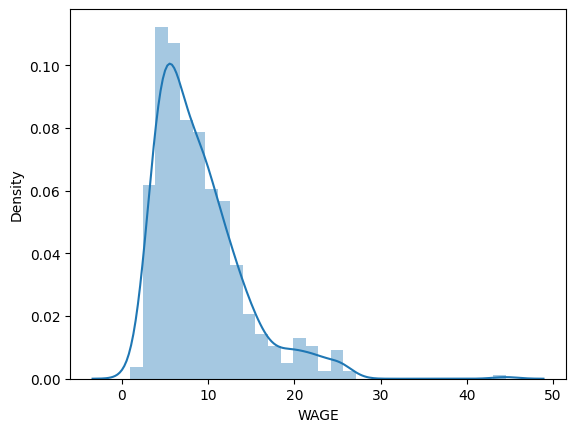

In [23]:
import seaborn as sns
display(pd.DataFrame(df['WAGE'].describe()))
sns.distplot(df['WAGE']);

In [24]:
categorical_list

Index(['SOUTH', 'SEX', 'UNION', 'RACE', 'OCCUPATION', 'SECTOR', 'MARR'], dtype='object')

In [26]:
# ▶ sample col eda
eda_df1 = df.groupby('OCCUPATION')['WAGE'].agg(WAGE_mean =('mean')).reset_index()
eda_df1

,OCCUPATION,WAGE_mean
0,1,12.704000
1,2,7.592632
2,3,7.422577
3,4,6.537470
4,5,11.947429
5,6,8.426474


In [30]:
eda_df2 = df.groupby('MARR')['WAGE'].agg(WAGE_mean =('mean')).reset_index()
eda_df2

,MARR,WAGE_mean
0,0,8.311848
1,1,9.398486


```
* 현재 수준으로 분석을 진행해도 문제 없음
* 데이터의 개수가 적으므로, 가능하다면 추가 데이터 확보가 더 요청 할 것
```

### · Feature Engineering
---
> **Target 변수와의 의미있는 변수 선택하는 방법**

```
* Classification(분류) : bin(통)으로 구분 후 Target 변수와의 관계 파악
* Regression(회귀) : Target 변수와의 correlation을 확인하거나 bin(통)으로 구분 후 Target 변수와의 관계 파악
```

> **IV (Information Value)**

```
* Feature 하나가 Good(Target)과 Bad(Non-target)을 잘 구분해줄 수 있는지에 대한 정보량을 표현하는 방법론
* IV 수치가 클수록 Target과 Non-target을 잘 구분할 수 있는 정보량이 많은 Feature이고, IV 수치가 작을수록 정보량이 적은 Feature
* (Target data 구성비 - Non-target data 구성비) * WoE
* WoE(Weight of Evidence) = ln(Target data 구성비 / Non-target data 구성비)
* ln(자연로그)를 취하는 이유? : WoE의 최대, 최소값의 범위를 맞춰주기 위해 (1~∞ , -∞~1)
```

> #### **└ Numerical features**

In [ ]:
!pip install optbinning

In [32]:
numerical_list

['EDUCATION', 'EXPERIENCE', 'WAGE', 'AGE']

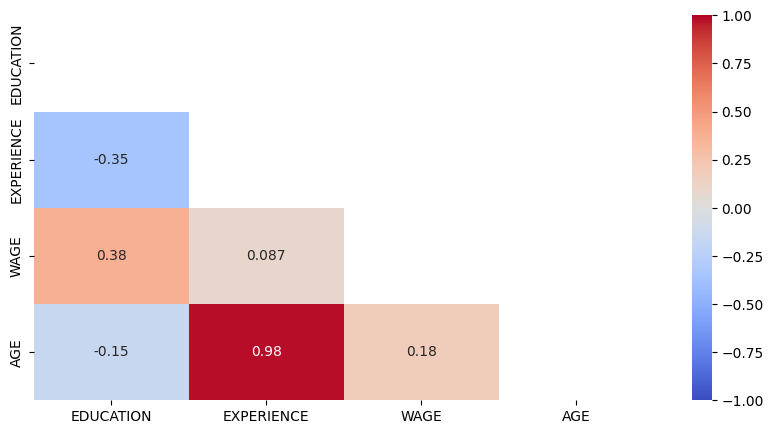

In [39]:
# ▶ heatmap plot
import seaborn as sns
import matplotlib.pyplot as plt
# ▶ 모든 조합, 상관계수 표현
df_pair = df[numerical_list]
mask = np.triu(np.ones_like(df_pair.corr(), dtype=np.bool))
sns.heatmap(df_pair.corr(), vmin = -1, vmax = +1, annot = True, cmap = 'coolwarm', mask = mask);
plt.gcf().set_size_inches(10, 5)

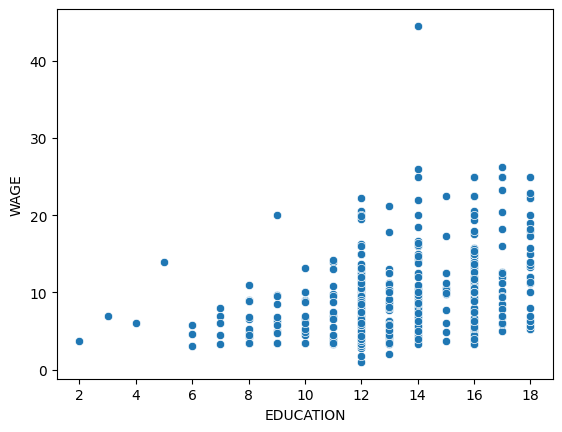

In [40]:
# ▶ scatter plot(Followers & Followers_gained)
sns.scatterplot(data = df, x='EDUCATION', y='WAGE');

In [41]:
val = 'EDUCATION'
df_mart = df.copy()
quantile  = df_mart[val].quantile(q=list(np.arange(0.05,1,0.05)), interpolation='higher')
quantile

0.05     9
0.10    10
0.15    11
0.20    12
0.25    12
0.30    12
0.35    12
0.40    12
0.45    12
0.50    12
0.55    12
0.60    13
0.65    14
0.70    14
0.75    15
0.80    16
0.85    16
0.90    17
0.95    18
Name: EDUCATION, dtype: int64

In [43]:
# ▶ Binning
df_mart = df.copy()
val = 'EDUCATION'

quantile  = df_mart[val].quantile(q=list(np.arange(0.05,1,0.05)), interpolation = 'nearest')
# quantile

# ▶ 그룹 초기화
df_mart['grp'] = 0

# ▶ 40%, 75% 기준으로 총 3개 구간화 진행
for i in  range(len(df_mart[val])) :
  if df_mart.loc[i, val] <= quantile.iloc[7] : # 40%
    df_mart.loc[i, 'grp'] = 1
  elif df_mart.loc[i, val] <= quantile.iloc[14] : # 75%
    df_mart.loc[i, 'grp'] = 2
  else : df_mart.loc[i, 'grp'] = 3

In [44]:
display(df_mart['grp'].value_counts())
display(df_mart['grp'].value_counts(normalize=True))

1    302
3    126
2    106
Name: grp, dtype: int64

1    0.565543
3    0.235955
2    0.198502
Name: grp, dtype: float64

In [45]:
pd.options.display.float_format = '{:.5f}'.format
df_mart.groupby('grp')['WAGE'].mean()

grp
1    7.47745
2    9.86708
3   12.02183
Name: WAGE, dtype: float64

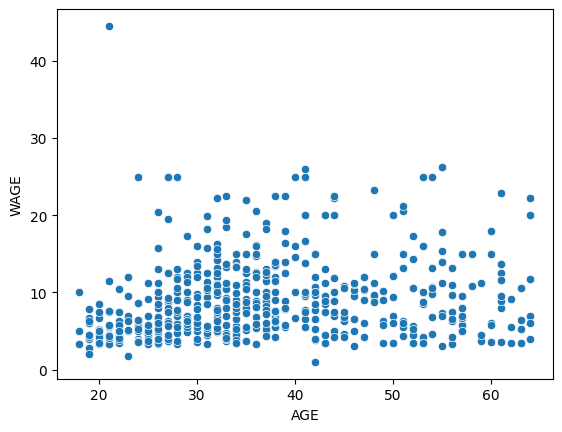

In [46]:
# ▶ scatter plot(Followers & Followers_gained)
sns.scatterplot(data = df, x='AGE', y='WAGE');

In [47]:
# ▶ Binning
df_mart = df.copy()
val = 'AGE'

quantile  = df_mart[val].quantile(q=list(np.arange(0.05,1,0.05)), interpolation = 'nearest')
# quantile

# ▶ 그룹 초기화
df_mart['grp'] = 0

# ▶ 40%, 75% 기준으로 총 3개 구간화 진행
for i in  range(len(df_mart[val])) :
  if df_mart.loc[i, val] <= quantile.iloc[3] : # 40%
    df_mart.loc[i, 'grp'] = 1
  elif df_mart.loc[i, val] <= quantile.iloc[14] : # 75%
    df_mart.loc[i, 'grp'] = 2
  else : df_mart.loc[i, 'grp'] = 3

In [48]:
# ▶ bin별 비중 비교
display(df_mart['grp'].value_counts())
display(df_mart['grp'].value_counts(normalize=True))

2    291
3    130
1    113
Name: grp, dtype: int64

2   0.54494
3   0.24345
1   0.21161
Name: grp, dtype: float64

In [49]:
quantile.iloc[3], quantile.iloc[14]

(26, 44)

In [50]:
# ▶ bin별 Target 변수와의 관계
pd.options.display.float_format = '{:.5f}'.format
df_mart.groupby('grp')['WAGE'].mean()

grp
1   6.45221
2   9.80649
3   9.50815
Name: WAGE, dtype: float64

> #### **└ Categorical features**

In [51]:
df[categorical_list].head()

,SOUTH,SEX,UNION,RACE,OCCUPATION,SECTOR,MARR
0,0,1,0,2,6,1,1
1,0,1,0,3,6,1,1
2,0,0,0,3,6,1,0
3,0,0,0,3,6,0,0
4,0,0,0,3,6,0,1


In [52]:
meta

,value,SOUTH,SEX,UNION,RACE,OCCUPATION,SECTOR,MARR
0,0,Person lives elsewhere,Male,Not union member,NaN,NaN,Other,Unmarried
1,1,Person lives in South,Female,Union member,Other,Management,Manufacturing,Married
2,2,NaN,NaN,NaN,Hispanic,Sales,Construction,NaN
3,3,NaN,NaN,NaN,White,Clerical,NaN,NaN
4,4,NaN,NaN,NaN,NaN,Service,NaN,NaN
5,5,NaN,NaN,NaN,NaN,Professional,NaN,NaN
6,6,NaN,NaN,NaN,NaN,Other,NaN,NaN


,SECTOR,mean
0,0,8.87277
1,1,9.60444
2,2,9.22083


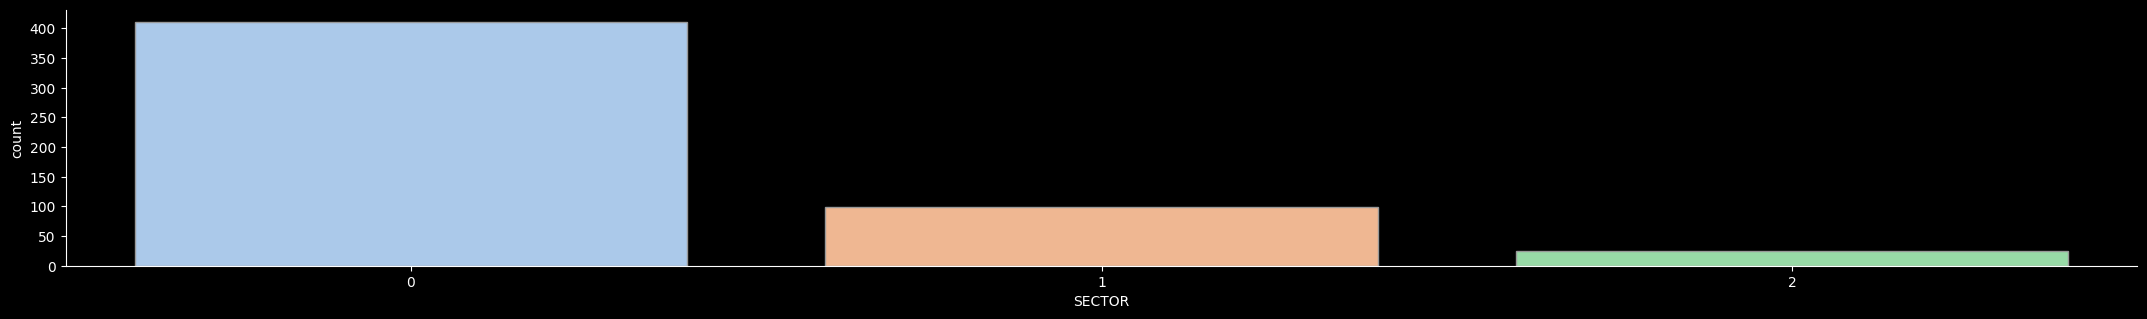

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use(['dark_background'])

# ▶ target 기준(hue,색상)으로 구분하여 Plot
sns.catplot(x="SECTOR", kind="count",palette="pastel", edgecolor=".6",data=df);
# plt.xticks(rotation=-20)
plt.gcf().set_size_inches(25, 3)

# ▶ sample col eda
eda_df = df.groupby('SECTOR')['WAGE'].agg(mean =('mean')).reset_index()
display(eda_df)

## **🥇Session 3**  
**┗ Modeling Process**  
---

### · Modeling
---
> **데이터 사전 준비**

```
* 모델은 숫자로 이루어진 형태의 Data만 인식 가능 (※ 문자형 변수 인코딩 필요)
* 모델링을 수행하기 위해 Feature와 예측하고자하는 값인 Y로 데이터를 나눔
* 학습과 예측을 위한 Train / Test set 분할
* Categorical value 인코딩
```
> **Model Selection (Regression)**

```
* 선형회귀 모델 (Ridge, Lasso, Elastic Net)
* 비선형회귀 모델 (polynomial, log모형)
* Tree 계열 Regression 모델
  - bagging 앙상블 (Randomforest)
  - boosting 앙상블 (lightGBM)
```


> **Model 학습**

```
* Model Selection 단계에서 선정한 모델들을 학습하고 성능을 기록
* 동일한 Data set, 동일한 환경에서 동일한 비교 지표로 성능을 비교
```

> #### **└ 데이터 사전 준비**

In [54]:
df.head()

,EDUCATION,SOUTH,SEX,EXPERIENCE,UNION,WAGE,AGE,RACE,OCCUPATION,SECTOR,MARR
0,8,0,1,21,0,5.10000,35,2,6,1,1
1,9,0,1,42,0,4.95000,57,3,6,1,1
2,12,0,0,1,0,6.67000,19,3,6,1,0
3,12,0,0,4,0,4.00000,22,3,6,0,0
4,12,0,0,17,0,7.50000,35,3,6,0,1


In [55]:
# ▶ 모델링을 학습하기 위한 Feature(X)와 Target(Y)데이터를 구분하는 단계
from sklearn.model_selection import train_test_split

X = df.drop(['WAGE'], axis=1)
Y = df['WAGE']

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=1234)

print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)

(373, 10)
(373,)
(161, 10)
(161,)


> #### **└ Linear Regression**

In [56]:
# ▶ Logistic Regression 표준화(standardization) (※정규화(0~1), Normalization)
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_sc = scaler.fit_transform(x_train)
x_test_sc = scaler.transform(x_test)

In [57]:
# ▶ Model 학습
from sklearn.linear_model import LinearRegression

LR = LinearRegression()
LR.fit(x_train_sc, y_train)

LinearRegression()

In [58]:
from sklearn import metrics

# ▶ 예측 및 성능 확인
y_pred_train = LR.predict(x_train_sc)
y_pred_test = LR.predict(x_test_sc)

print(metrics.r2_score(y_train, y_pred_train))
print(metrics.r2_score(y_test, y_pred_test))

0.28479951475809295
0.21389144177823738


In [59]:
# ▶ 과적합 문제, Train과 Test set에 성능을 최대한 줄여주는 것이 과적합을 방지
from sklearn.metrics import roc_auc_score

print("[Train]")
print('Mean Absolute Error:', metrics.mean_absolute_error(y_train, y_pred_train))
print('Mean Squared Error:', metrics.mean_squared_error(y_train, y_pred_train))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_train, y_pred_train)))
print('------------------------------------------')
print("[Test]")
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_test))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_test))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_test)))

[Train]
Mean Absolute Error: 3.1446938875417625
Mean Squared Error: 20.319455339546863
Root Mean Squared Error: 4.507710653929205
------------------------------------------
[Test]
Mean Absolute Error: 3.208463954748451
Mean Squared Error: 16.598588574987904
Root Mean Squared Error: 4.074136543488437


In [68]:
# ▶ 여러 Model의 성능 비교를 위한 빈 DataFrame 생성
df_comparison = pd.DataFrame(columns = ['model', 'r2_train', 'r2_test', 'RMSE_train', 'RMSE_test'])
df_comparison.columns = ['model', 'r2_train', 'r2_test', 'RMSE_train', 'RMSE_test']
df_comparison

,model,r2_train,r2_test,RMSE_train,RMSE_test


In [69]:
# ▶ LR model에 대한 성능 값 추가
import sklearn.metrics as metrics

lr_re = pd.DataFrame({ 'model' : ['LR'],
                      'r2_train' :  metrics.r2_score(y_train,y_pred_train),
                      'r2_test' : metrics.r2_score(y_test,y_pred_test),
                      'RMSE_train' : np.sqrt(metrics.mean_squared_error(y_train, y_pred_train)),
                      'RMSE_test' : np.sqrt(metrics.mean_squared_error(y_test, y_pred_test)),}
                    )

df_comparison = df_comparison.append(lr_re)
df_comparison

,model,r2_train,r2_test,RMSE_train,RMSE_test
0,LR,0.28480,0.21389,4.50771,4.07414


> #### **└ Random Forest**

In [70]:
# ▶ RandomForest
from sklearn.ensemble import RandomForestRegressor

rfc = RandomForestRegressor()
rfc.fit(x_train, y_train)

# ▶ 예측 및 성능 확인
y_pred_train = rfc.predict(x_train)
y_pred_test = rfc.predict(x_test)

print(metrics.r2_score(y_train, y_pred_train))
print(metrics.r2_score(y_test, y_pred_test))

0.85394657128819
0.16849387351269818


In [71]:
# ▶ 과적합 문제, Train과 Test set에 성능을 최대한 줄여주는 것이 과적합을 방지
from sklearn.metrics import roc_auc_score

print("[Train]")
print('Mean Absolute Error:', metrics.mean_absolute_error(y_train, y_pred_train))
print('Mean Squared Error:', metrics.mean_squared_error(y_train, y_pred_train))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_train, y_pred_train)))
print('------------------------------------------')
print("[Test]")
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_test))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_test))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_test)))

[Train]
Mean Absolute Error: 1.3609708183326945
Mean Squared Error: 4.149502388681297
Root Mean Squared Error: 2.0370327411903073
------------------------------------------
[Test]
Mean Absolute Error: 3.312278652026029
Mean Squared Error: 17.557152821698523
Root Mean Squared Error: 4.190125633164061


In [72]:
# ▶ BayesianOptimization 설치
!pip install bayesian-optimization

In [73]:
# ▶ BayesianOptimization
import numpy as np
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score


def model_evaluate(n_estimators, maxDepth):
    clf = RandomForestRegressor(
        n_estimators= int(n_estimators),
        max_depth= int(maxDepth))
    scores = cross_val_score(clf, x_train, y_train, cv=5, scoring='r2')
    return np.mean(scores)


def bayesOpt(x_train, y_train):
    clfBO = BayesianOptimization(model_evaluate, {'n_estimators':  (100, 300),
                                                  'maxDepth': (2, 6)
                                                 })
    clfBO.maximize(init_points=5, n_iter=10)
    print(clfBO.res)

bayesOpt(x_train, y_train)

|   iter    |  target   | maxDepth  | n_esti... |
-------------------------------------------------
| 1         | 0.1446    | 4.515     | 104.5     |
| 2         | 0.1564    | 2.721     | 142.5     |
| 3         | 0.151     | 3.228     | 216.8     |
| 4         | 0.09376   | 5.338     | 149.1     |
| 5         | 0.1567    | 2.196     | 291.6     |
| 6         | 0.1542    | 2.649     | 189.7     |
| 7         | 0.1469    | 2.492     | 145.1     |
| 8         | 0.1452    | 3.582     | 295.5     |
| 9         | 0.1579    | 2.998     | 287.4     |
| 10        | 0.1415    | 2.121     | 137.1     |
| 11        | 0.09579   | 6.0       | 289.9     |
| 12        | 0.1361    | 2.235     | 288.3     |
| 13        | 0.1551    | 2.759     | 296.4     |
| 14        | 0.1174    | 3.622     | 286.1     |
| 15        | 0.1396    | 4.748     | 121.6     |
[{'target': 0.14462040418360098, 'params': {'maxDepth': 4.514756384603073, 'n_estimators': 104.50365341553135}}, {'target': 0.1563916485212242, 'param

In [74]:
# ▶ RandomForest
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as metrics
from sklearn.metrics import roc_auc_score

rfc = RandomForestRegressor(n_estimators=287, max_depth = 3, random_state= 1121)
rfc.fit(x_train, y_train)

# ▶ 예측
y_pred_train = rfc.predict(x_train)
y_pred_test = rfc.predict(x_test)


rfc_re = pd.DataFrame({ 'model' : ['RFC(BO)'],
                      'r2_train' :  metrics.r2_score(y_train,y_pred_train),
                      'r2_test' : metrics.r2_score(y_test,y_pred_test),
                      'RMSE_train' : np.sqrt(metrics.mean_squared_error(y_train, y_pred_train)),
                      'RMSE_test' : np.sqrt(metrics.mean_squared_error(y_test, y_pred_test)),}
                    )
# rfc_re

df_comparison = df_comparison.append(rfc_re)
df_comparison.reset_index(drop=True, inplace = True)

In [75]:
df_comparison

,model,r2_train,r2_test,RMSE_train,RMSE_test
0,LR,0.28480,0.21389,4.50771,4.07414
1,RFC(BO),0.38520,0.16447,4.17937,4.20025


> #### **└ LightGBM**

In [76]:
# ▶ lightGBM
import lightgbm as lgbm
from lightgbm import LGBMRegressor

LGBM = lgbm.LGBMRegressor()
LGBM.fit(x_train, y_train)

LGBMRegressor()

In [77]:
# ▶ 예측
y_pred_train = LGBM.predict(x_train)
y_pred_test = LGBM.predict(x_test)

print(metrics.r2_score(y_train, y_pred_train))
print(metrics.r2_score(y_test, y_pred_test))

0.6452206500138179
0.17783160644794171


In [78]:
# ▶ AUC
print("[Train]")
print('Mean Absolute Error:', metrics.mean_absolute_error(y_train, y_pred_train))
print('Mean Squared Error:', metrics.mean_squared_error(y_train, y_pred_train))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_train, y_pred_train)))
print('------------------------------------------')
print("[Test]")
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_test))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_test))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_test)))


[Train]
Mean Absolute Error: 2.2197912330578844
Mean Squared Error: 10.079583705818335
Root Mean Squared Error: 3.174836012429356
------------------------------------------
[Test]
Mean Absolute Error: 3.2424005120492665
Mean Squared Error: 17.359987702970102
Root Mean Squared Error: 4.16653185550886


In [ ]:
def lgb_evaluate(learning_rate, n_estimators, maxDepth):
    clf = LGBMRegressor(
        learning_rate= float(learning_rate),
        n_estimators= int(n_estimators),
        max_depth= int(maxDepth))
    scores = cross_val_score(clf, x_train, y_train, cv=5, scoring='r2')
    return np.mean(scores)

def bayesOpt(train_x, train_y):
    lgbBO = BayesianOptimization(lgb_evaluate, {'learning_rate': (0.005, 0.05),
                                                'n_estimators': (100, 400),
                                                'maxDepth': (2, 6)
                                               })
    lgbBO.maximize(init_points=5, n_iter=15)
    print(lgbBO.res)

bayesOpt(x_train, y_train)

|   iter    |  target   | learni... | maxDepth  | n_esti... |
-------------------------------------------------------------
| 1         | 0.2735    | 0.01239   | 3.848     | 308.0     |
| 2         | 0.2656    | 0.03069   | 3.949     | 184.5     |
| 3         | 0.2351    | 0.04385   | 5.618     | 160.2     |
| 4         | 0.2488    | 0.01815   | 5.706     | 304.8     |
| 5         | 0.2741    | 0.04612   | 2.855     | 286.0     |
| 6         | 0.2723    | 0.04639   | 2.936     | 289.0     |
| 7         | 0.2121    | 0.03268   | 5.282     | 287.1     |
| 8         | 0.2725    | 0.0333    | 3.147     | 112.3     |
| 9         | 0.2674    | 0.02439   | 3.035     | 112.3     |
| 10        | 0.2637    | 0.04736   | 3.98      | 112.3     |
| 11        | 0.2737    | 0.0363    | 3.423     | 113.0     |
| 12        | 0.2798    | 0.03702   | 2.607     | 286.9     |
| 13        | 0.2689    | 0.05      | 2.0       | 286.4     |
| 14        | 0.2856    | 0.02151   | 2.191     | 287.9     |
| 15    

In [79]:
# ▶ lightGBM
from lightgbm import LGBMRegressor

# ▶ setting the parameters
LGBM = LGBMRegressor(learning_rate=0.02, n_estimators=287, max_depth=3, random_state=1234)
LGBM.fit(x_train, y_train)


# ▶ 예측
y_pred_train = LGBM.predict(x_train)
y_pred_test = LGBM.predict(x_test)

lgbm_re = pd.DataFrame({ 'model' : ['LGBM(BO)3'],
                      'r2_train' :  metrics.r2_score(y_train,y_pred_train),
                      'r2_test' : metrics.r2_score(y_test,y_pred_test),
                      'RMSE_train' : np.sqrt(metrics.mean_squared_error(y_train, y_pred_train)),
                      'RMSE_test' : np.sqrt(metrics.mean_squared_error(y_test, y_pred_test)),}
                    )
# lgbm_re
df_comparison = df_comparison.append(lgbm_re)
df_comparison.reset_index(drop=True, inplace = True)

In [80]:
df_comparison

,model,r2_train,r2_test,RMSE_train,RMSE_test
0,LR,0.28480,0.21389,4.50771,4.07414
1,RFC(BO),0.38520,0.16447,4.17937,4.20025
2,LGBM(BO)3,0.45447,0.28936,3.93686,3.87363


### · Modeling evaluation
---
> **전체 모델 성능 평가**

```
* Hyper-parameter tunning 후 전체 모델 성능 비교
```

In [81]:
df_comparison.style.background_gradient(cmap='coolwarm', low=1)

,model,r2_train,r2_test,RMSE_train,RMSE_test
0,LR,0.284800,0.213891,4.507711,4.074137
1,RFC(BO),0.385195,0.164471,4.179368,4.200250
2,LGBM(BO)3,0.454474,0.289364,3.936859,3.873628


> **해석**

```
* Regression(회귀)문제이므로 R2는 높을수록, RMSE는 낮을수록 성능이 좋은 것임
* Test set 기준 LGBM(BO)가 가장 R2가 높음
* Test set 기준 LGBM(BO)의 Loss(RMSE)가 가장 낮음
* LGBM(BO) 선택
```

### · Summary
---
> **모델 해석 및 현업 Operation 설계**

```
* 최종 선택된 모델의 중요 변수 탐색
* 모델 Operation Check 사항 점검
```

> #### **└ 모델 해석**

In [82]:
# ▶ shap
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 8.8 MB/s eta 0:00:00


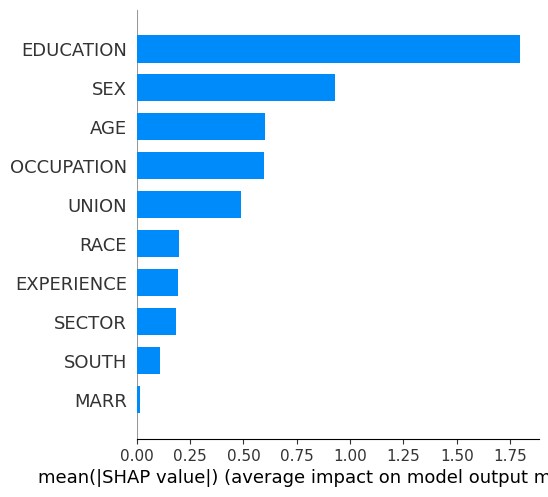

In [83]:
import shap
plt.style.use(['default'])

shap.initjs()
# ▶ LGBM shap
explainer = shap.TreeExplainer(LGBM)
shap_values = explainer.shap_values(x_train)
shap.summary_plot(shap_values, x_train, feature_names=x_train.columns, plot_type="bar", show=False)
plt.gcf().set_size_inches(5,5)
plt.show()

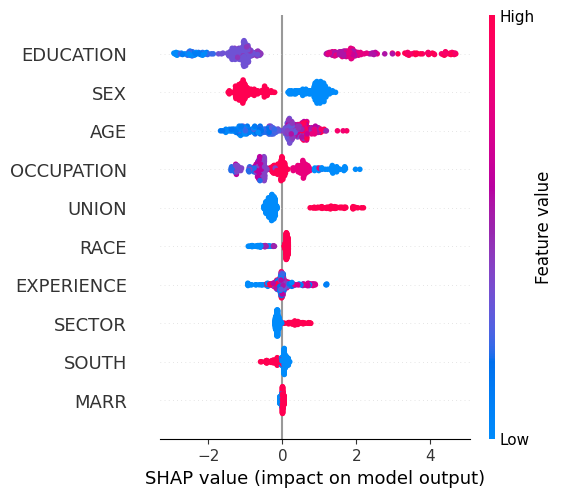

In [ ]:
# ▶ LGBM shap global
shap.initjs()
shap.summary_plot(shap_values, x_train, show=False)
plt.gcf().set_size_inches(5,5)
plt.show()

In [ ]:
# ▶ LGBM shap local
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[2] , x_train.iloc[1,:])

In [ ]:
x_train.iloc[1,:]

EDUCATION     12
SOUTH          1
SEX            1
EXPERIENCE    10
UNION          0
AGE           28
RACE           1
OCCUPATION     6
SECTOR         1
MARR           1
Name: 93, dtype: int64


> #### **└ wrap up**

```
* 데이터 전처리
* 데이터 EDA
* Feature Engineering
* Modeling
* XAI
* Model Operation
```